This notebook contains the complete Python code to train all models (Lasso, PCA + Linear Regression, XGBoost).

You do not need to run this file to see our result. Our final, pre-trained models (`.joblib`) are already included in our submission. This notebook is provided for full transparency in case you wish to verify our training process.

A `train.py` script with the same logic is also provided for local execution.

To Run This Notebook:
1. Mount Google Drive (necessary for this colab notebook unless you are running using `train.py`)
2. For the best experience, we recommend enabling a GPU and this is the reason why we provide this notebook in addition to the python script
3. Run All Cells. This will create new `.joblib` model files in the `models` folder

In [ ]:
# Uncomment the code below to run on Google colab
import sys
from google.colab import drive

drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/src"
sys.path.append(project_path)

print(f"Added {project_path} to Python path")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Added /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/src to Python path


# Import additional packages

In [ ]:
from preprocessing import build_preprocessor, split_data
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import joblib
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import shap
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
import joblib

In [ ]:
file_path = '/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/data/insurance.csv'
df = pd.read_csv(file_path)
X_train, X_test, y_train, y_test = split_data(df) # Assign only the variables needed for non-log models
X_train.head()

,age,sex,bmi,children,smoker,region
1318,35,male,39.71,4,no,northeast
1054,27,female,21.47,0,no,northwest
949,25,male,29.70,3,yes,southwest
127,52,female,37.40,0,no,southwest
977,26,male,29.15,1,no,southeast


In [ ]:
# Build the preprocessor using the build_preprocessor function from preprocessing.py
preprocessor = build_preprocessor()
print("Preprocessor built successfully.")

process_features built successfully.
Preprocessor built successfully.


### PCA

create_features built successfully.
Explained Variance Ratio by Component:
Principal Component 1: 0.4013
Principal Component 2: 0.2326
Principal Component 3: 0.0684
Principal Component 4: 0.0521
Principal Component 5: 0.0494
Principal Component 6: 0.0463
Principal Component 7: 0.0411
Principal Component 8: 0.0287
Principal Component 9: 0.0158
Principal Component 10: 0.0153
Principal Component 11: 0.0123
Principal Component 12: 0.0085
Principal Component 13: 0.0070
Principal Component 14: 0.0065
Principal Component 15: 0.0050
Principal Component 16: 0.0036
Principal Component 17: 0.0027
Principal Component 18: 0.0018
Principal Component 19: 0.0015

Cumulative Explained Variance:
Number of Components: 1, Cumulative Variance: 0.4013
Number of Components: 2, Cumulative Variance: 0.6339
Number of Components: 3, Cumulative Variance: 0.7023
Number of Components: 4, Cumulative Variance: 0.7544
Number of Components: 5, Cumulative Variance: 0.8038
Number of Components: 6, Cumulative Variance: 0.

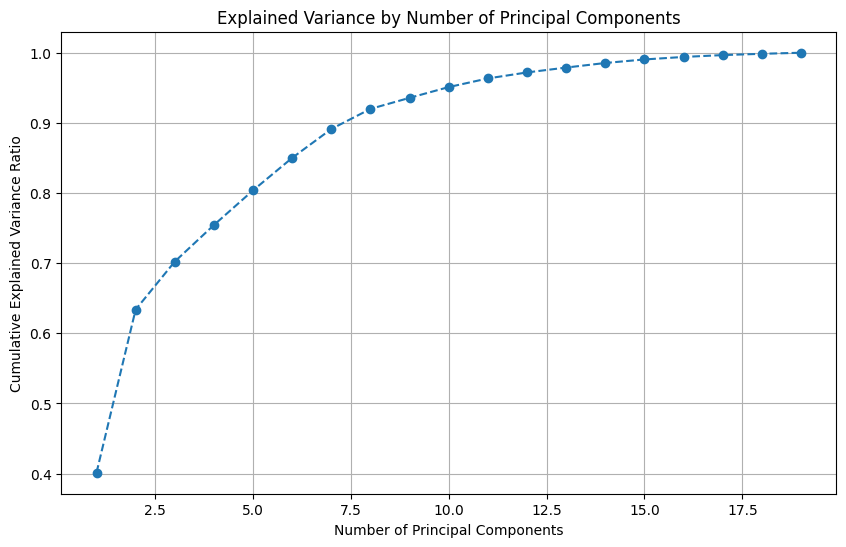

In [ ]:
# 'preprocessor' is an existing ColumnTransformer object
# df' is  original DataFrame

# Separate features (X) from the original DataFrame
# 'charges' is the target column name (though not used for PCA features)
try:
    X = df.drop('charges', axis=1)
except NameError:
    print("Original DataFrame 'df' not found. Please ensure the data is loaded.")
    raise # Stop execution if df is not available
except KeyError:
    print("Column 'charges' not found in df. Please ensure the target column name is correct.")
    raise


# Create pipeline with the preprocessor and PCA
# 'preprocessor' object is already defined and available
try:
    pca_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Use the existing preprocessor
        ('pca', PCA())
    ])
except NameError:
     print("Preprocessor object 'preprocessor' not found. Please ensure the preprocessor is defined in a previous cell.")
     raise


# fit the PCA pipeline on the features from the original df
pca_pipeline.fit(X)

# access the fitted PCA object from the pipeline
pca = pca_pipeline.named_steps['pca']

# analyze the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio by Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio:.4f}")

print("\nCumulative Explained Variance:")
for i, cumulative_ratio in enumerate(cumulative_explained_variance):
     print(f"Number of Components: {i+1}, Cumulative Variance: {cumulative_ratio:.4f}")


# visualizing the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


In [ ]:
# assuming 'pca' object is available from the previous PCA cell
# assuming 'X' (features before PCA) is available to get original feature names
# assuming 'pca_pipeline' is available from the previous PCA cell

try:
    # Access the fitted preprocessor from the pca_pipeline
    fitted_preprocessor_pca = pca_pipeline.named_steps['preprocessor']

    # Access the 'process_features' (ColumnTransformer) step within the fitted preprocessor pipeline
    fitted_process_features_pca = fitted_preprocessor_pca.named_steps['process_features']

    # Get the feature names after preprocessing using get_feature_names_out() from the fitted ColumnTransformer
    preprocessed_feature_names = fitted_process_features_pca.get_feature_names_out()


    # get the loadings (components) from the fitted PCA object
    # Access the fitted PCA object from the pipeline
    pca = pca_pipeline.named_steps['pca']
    loadings = pca.components_


    # df to display the loadings
    # rows are principal components, columns are original features after preprocessing
    loadings_df = pd.DataFrame(loadings, columns=preprocessed_feature_names, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

    print("Principal Component Loadings:")
    display(loadings_df)

    # view the loadings sorted by absolute value for a specific component

except NameError:
    print("PCA object 'pca', features 'X', or 'pca_pipeline' not found. Please ensure the PCA and data splitting cells were executed.")
except AttributeError:
     print("Could not retrieve feature names after preprocessing. Ensure ColumnTransformer and its transformers are structured as expected.")
except Exception as e:
    print(f"An error occurred while displaying loadings: {e}")

Principal Component Loadings:


,num__age,num__bmi,num__age_squared,cat__sex_male,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__children_1,cat__children_2,cat__children_3,cat__children_4,cat__children_5,cat__is_obese_1,cat__smoker_x_obese_1,cat__is_male_x_smoker_1,cat__smoker_in_northwest_1,cat__smoker_in_southeast_1,cat__smoker_in_southwest_1
PC1,0.692644,0.182666,0.693117,-0.005232,-0.007165,-0.007128,0.010293,0.002467,-0.001586,-0.000451,0.012585,-0.000363,-0.002986,0.076721,0.009637,-0.003227,-0.001066,0.004808,-0.006372
PC2,-0.141348,0.882909,-0.137188,0.034959,0.019643,-0.069666,0.134256,-0.008381,-0.003321,0.011771,-0.003747,0.001275,-0.001433,0.381294,0.096058,0.029184,-0.011892,0.035868,0.007520
PC3,0.018074,-0.102759,0.015937,0.437508,0.575532,-0.077855,0.155773,-0.069886,-0.032414,0.032481,0.023299,-0.004976,-0.006263,-0.038150,0.352730,0.468588,0.095223,0.244580,0.118112
PC4,0.006977,-0.054591,0.006109,-0.303393,0.003022,-0.064243,0.668949,-0.603937,0.104787,-0.045353,-0.039622,-0.008980,-0.004170,-0.099618,-0.036470,-0.078336,-0.022162,0.183747,-0.148888
PC5,-0.007626,0.053717,-0.002800,0.140584,0.002086,0.760787,-0.248668,-0.495170,-0.168064,0.110783,0.068398,0.001720,-0.014941,0.080758,0.005370,0.018434,0.163018,-0.069202,-0.088193
PC6,0.006539,0.002504,0.001422,0.774167,-0.354753,-0.054009,0.144052,-0.115477,0.327243,-0.199069,-0.065985,0.003620,0.005839,-0.041435,-0.227809,-0.061313,-0.101467,-0.083082,-0.109876
PC7,0.006504,0.039542,-0.011640,-0.242812,0.193618,0.204059,-0.207866,0.013152,0.756895,-0.458771,-0.073564,-0.010922,-0.014835,0.015563,0.117701,0.071730,0.086759,0.012590,0.027454
PC8,0.038361,0.001603,-0.024371,-0.000559,0.001072,0.045895,-0.014169,0.020255,0.354073,0.713594,-0.598109,-0.020729,-0.015318,-0.015665,0.022385,-0.001966,-0.019571,-0.003595,0.032928
PC9,0.014894,-0.375905,-0.014275,0.006468,-0.089999,-0.128126,-0.020693,-0.112218,0.156753,0.142943,0.242446,-0.055570,-0.026711,0.809371,0.199656,-0.066029,-0.113708,-0.022231,-0.019408
PC10,0.090122,0.115937,-0.103533,-0.005683,0.001026,0.043843,0.069195,0.097840,0.344745,0.435459,0.742580,-0.067224,-0.041906,-0.263654,-0.111268,0.035187,0.038338,0.015544,-0.019606


### LASSO Regression

In [ ]:
# # training and tuning a Lasso Regression model (using LassoCV)
# # LassoCV performs cross-validation to find the best alpha (primary hyperparameter tuning)

# # Define the Lasso model
# lasso = LassoCV(cv=5, random_state=42, max_iter=10000)

# # Create the full pipeline including the existing preprocessor and Lasso
# # Assuming 'preprocessor' object is already defined and available
# try:
#     lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                      ('lasso', lasso)])
# except NameError:
#      print("Preprocessor object 'preprocessor' not found. Please ensure the preprocessor is defined in a previous cell.")
#      raise


# # Fit the full pipeline to the training data (using X_train from original df)
# lasso_pipeline.fit(X_train, y_train)

# print("Full Lasso Pipeline Training Complete.")

# # Make predictions on the test set (using X_test from original df)
# y_pred = lasso_pipeline.predict(X_test)

# # Evaluate the model
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print(f"\nTest Set Evaluation (Full Pipeline):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")

# # Accessing coefficients from the Lasso model within the pipeline
# # Get the fitted preprocessor from the pipeline
# fitted_preprocessor_pipeline = lasso_pipeline.named_steps['preprocessor']

# # Access the 'process_features' (ColumnTransformer) step within the fitted preprocessor pipeline
# fitted_process_features = fitted_preprocessor_pipeline.named_steps['process_features']


# # Get the feature names after preprocessing using get_feature_names_out() from the fitted ColumnTransformer
# try:
#     all_feature_names = fitted_process_features.get_feature_names_out()
#     fitted_lasso = lasso_pipeline.named_steps['lasso']

#     coefficients = fitted_lasso.coef_

#     if len(coefficients) == len(all_feature_names):
#         coefficients_series = pd.Series(coefficients, index=all_feature_names)

#         print("\nFeature Importance (Absolute Value of Coefficients - Full Pipeline):")
#         display(coefficients_series.abs().sort_values(ascending=False))

#         print("\nFeature Coefficients (Full Pipeline):")
#         display(coefficients_series.sort_values(key=abs, ascending=False))
#     else:
#         print(f"Mismatch between number of coefficients ({len(coefficients)}) and feature names ({len(all_feature_names)}). Cannot create coefficients series.")

# except Exception as e:
#     print(f"\nAn error occurred while displaying coefficients: {e}")

# PCA + Linear Regression

In [ ]:
# Assuming X_train, X_test, y_train, y_test are already defined from the data split
# preprocessor object is already defined and available

# PCA step
#  choose the number of components based on your PCA analysis (e.g from the explained variance plot)
# we are keeping 95% variance:
n_components_to_keep = 10 #number of components based on our analysis

pca = PCA(n_components=n_components_to_keep)

# Define the Linear Regression model
# No hyperparameters to tune for basic Linear Regression
linear_reg_pca = LinearRegression()

# Creating full pipeline including preprocessor, PCA, and Linear Regression
try:
    linear_reg_pca_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                             ('pca', pca),
                                             ('linear_regression', linear_reg_pca)])
except NameError:
     print("Preprocessor object 'preprocessor' not found. Please ensure the preprocessor is defined in a previous cell.")
     raise

print("Linear Regression Pipeline with PCA built successfully.")

# Fit the full pipeline to the training data
linear_reg_pca_pipeline.fit(X_train, y_train)

print("Full Linear Regression Pipeline with PCA Training Complete.")

# Make predictions on the test set
y_pred_linear_reg_pca = linear_reg_pca_pipeline.predict(X_test)

# Evaluate the model
rmse_linear_reg_pca = np.sqrt(mean_squared_error(y_test, y_pred_linear_reg_pca))
mae_linear_reg_pca = mean_absolute_error(y_test, y_pred_linear_reg_pca)

print(f"\nTest Set Evaluation (Full Pipeline with PCA - Linear Regression):")
print(f"RMSE: {rmse_linear_reg_pca:.2f}")
print(f"MAE: {mae_linear_reg_pca:.2f}")

# Accessing coefficients from the Linear Regression model within the pipeline
# Note: These coefficients are for the principal components, not the original features
try:
    fitted_linear_reg_pca = linear_reg_pca_pipeline.named_steps['linear_regression']
    coefficients_linear_reg_pca = fitted_linear_reg_pca.coef_

    print("\nFeature Coefficients (Linear Regression with PCA - Coefficients for Principal Components):")
    # Display coefficients with index representing the principal component number
    coefficients_linear_reg_pca_series = pd.Series(coefficients_linear_reg_pca, index=[f'PC{i+1}' for i in range(len(coefficients_linear_reg_pca))])
    display(coefficients_linear_reg_pca_series.sort_values(key=abs, ascending=False))

except Exception as e:
    print(f"\nAn error occurred while displaying coefficients: {e}")

Linear Regression Pipeline with PCA built successfully.
create_features built successfully.
Full Linear Regression Pipeline with PCA Training Complete.
create_features built successfully.

Test Set Evaluation (Full Pipeline with PCA - Linear Regression):
RMSE: 0.46
MAE: 0.30

Feature Coefficients (Linear Regression with PCA - Coefficients for Principal Components):


,0
PC3,0.897934
PC6,-0.582536
PC7,0.385693
PC1,0.348593
PC10,0.272240
PC5,-0.121203
PC8,0.111833
PC4,0.072689
PC9,-0.034652
PC2,0.019401


### Interpretation of Linear Regression Model with PCA Loadings
We can interpret the importance of the original features in the model by understanding how they contribute to the principal components that the Linear Regression model utilizes.

The Linear Regression coefficients highlight the principal components with the strongest influence on predicted charges. Unlike Lasso, Linear Regression does not perform feature selection by setting coefficients to zero, but the magnitude of the coefficient still indicates the strength of the linear relationship between the principal component and the target variable. The PCA loadings reveal which original preprocessed features are most strongly associated with each principal component. The sign of the loading indicates the direction of the feature's contribution to the component, and combined with the component's Linear Regression coefficient, determines whether that feature's contribution through that component increases or decreases the predicted charge.

Examination of the principal components with the largest absolute Linear Regression coefficients:

PC3 (Coefficient: +0.8979): This is the most influential component based on coefficient magnitude. Its high positive coefficient indicates that moving in the positive direction of PC3 is strongly associated with increased charges. Based on the loadings in cell `T2FR9SJuuF7I`, PC3 is heavily dominated by **`cat__smoker_yes`** (high positive loading), **`cat__is_male_x_smoker_1`** (high positive loading), and **`cat__smoker_x_obese_1`** (high positive loading). This means that being a smoker and having interactions related to sex and obesity contribute positively to PC3. Since PC3 has a positive coefficient, a positive contribution to PC3 from these features leads to **higher predicted charges**.

PC6 (Coefficient: -0.5825): With a large negative coefficient, the positive direction of PC6 is associated with decreased charges. PC6 (from cell `T2FR9SJuuF7I`) is primarily influenced by **`cat__sex_male` (positive loading) and **`cat__smoker_yes`** (negative loading). Being male contributes positively to PC6, while being a smoker contributes negatively. The negative coefficient means that a positive contribution to PC6 leads to lower charges. Therefore, being male (positive loading) contributes to lower charges through PC6, while being a smoker (negative loading, pushing PC6 in the negative direction) contributes to higher charges through PC6. This component seems to capture a pattern where being male is associated with lower costs *within this component's context*, and being a smoker is associated with higher costs.

PC7 (Coefficient: +0.3857): This component has a positive coefficient, linking its positive direction to increased charges. Its dominant features (from cell `T2FR9SJuuF7I`) are **`cat__children_1`** (positive loading) and **`cat__sex_male`** (positive loading). Both having one child and being male contribute positively to PC7. Since PC7 has a positive coefficient, a positive contribution to PC7 from these features leads to **higher predicted charges**.

PC1 (Coefficient: +0.3486): This component has a positive coefficient, linking its positive direction to increased charges. It is overwhelmingly influenced by **`num__age`** and **`num__age_squared`** (both with strong positive loadings from cell `T2FR9SJuuF7I`). Increasing age contributes positively to PC1. Since PC1 has a positive coefficient, a positive contribution to PC1 from age leads to **higher predicted charges**.

PC10 (Coefficient: +0.2722): This component has a positive coefficient, linking its positive direction to increased charges. Its dominant features (from cell `T2FR9SJuuF7I`) are related to having 3 children and age. Since PC10 has a positive coefficient, a positive contribution to PC10 from these features leads to **higher predicted charges**.

PC5 (Coefficient: -0.1212): With a negative coefficient, the positive direction of PC5 is associated with decreased charges. PC5 (from cell `T2FR9SJuuF7I`) is influenced by **`cat__region_northwest`** (strong positive loading), **`cat__region_southwest`** (strong negative loading), and **`cat__children_1`** (moderate negative loading). Being in the Northwest contributes positively to PC5, leading to **lower predicted charges** (due to the negative coefficient). Being in the Southwest or having 1 child contributes negatively to PC5, leading to **higher predicted charges** (due to the negative coefficient and pushing PC5 in the negative direction).

PC8 (Coefficient: +0.1118): This component has a positive coefficient, linking its positive direction to increased charges. Its dominant features (from cell `T2FR9SJuuF7I`) are related to differentiating between 2 and 3 children. Since PC8 has a positive coefficient, a positive contribution to PC8 from these features leads to **higher predicted charges**.

PC4 (Coefficient: +0.0727): This component has a positive coefficient, linking its positive direction to increased charges. Its dominant features (from cell `T2FR9SJuuF7I`) are related to distinguishing Southeast and Southwest regions. Since PC4 has a positive coefficient, a positive contribution to PC4 from these features leads to **higher predicted charges**.

PC9 (Coefficient: -0.0347): With a negative coefficient, the positive direction of PC9 is associated with decreased charges. PC9 (from cell `T2FR9SJuuF7I`) is primarily related to obesity and BMI. Being obese/higher BMI contributes positively to PC9. Since PC9 has a negative coefficient, a positive contribution to PC9 from these features leads to **lower predicted charges** (due to the negative coefficient).

PC2 (Coefficient: +0.0194): This component has a positive coefficient, linking its positive direction to increased charges. Its dominant feature (from cell `T2FR9SJuuF7I`) is primarily BMI. Being higher BMI contributes positively to PC2. Since PC2 has a positive coefficient, a positive contribution to PC2 from these features leads to **higher predicted charges**.


**Conclusion:**

By examining the loadings of the important principal components and their corresponding Linear Regression coefficients, we can infer the directional impact of the most influential original features on predicted charges. The analysis highlights that **smoking and its interactions**, **age**, **sex**, **number of children**, **obesity/BMI**, and **regional factors** are key drivers. Specifically, based on the dominant contributions to the most influential principal components:

*   **Smoking and its interactions (Smoker, Smoker x Male, Smoker x Obese):** Associated with **Higher Charges** (primarily through PC3).
*   **Age:** Associated with **Higher Charges** (primarily through PC1 and PC10).
*   **Being Male:** Associated with **Higher Charges** (through PC7) but potentially **Lower Charges** through PC6 (in combination with not smoking). The overall effect depends on the balance across components.
*   **Having 1 Child:** Associated with **Higher Charges** (through PC5 and PC7).
*   **Being Obese/Higher BMI:** Associated with **Higher Charges** (primarily through PC2) and potentially **Lower Charges** through PC9. The overall effect depends on the balance across components.
*   **Northwest Region:** Associated with **Lower Charges** (through PC5).
*   **Southwest Region:** Associated with **Higher Charges** (through PC5 and PC4).
*   **Having 2 Children:** Associated with patterns that differentiate from having 3 children (PC8).
*   **Having 3 Children:** Associated with patterns that differentiate from having 2 children and also related to age (PC8, PC10).
*   **Southeast Region:** Associated with patterns that differentiate from the Southwest region (PC4).

These findings provide insight into which feature combinations are most strongly related to insurance charges in this dataset, as captured by the principal components and utilized by the Linear Regression model.

# Lasso

In [ ]:
# training and tuning a Lasso Regression model (using LassoCV)
# LassoCV performs cross-validation to find the best alpha (primary hyperparameter tuning)

# Define the Lasso model
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)

# Create the full pipeline including the existing preprocessor and Lasso
# Assuming 'preprocessor' object is already defined and available
try:
    lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('lasso', lasso)])
except NameError:
     print("Preprocessor object 'preprocessor' not found. Please ensure the preprocessor is defined in a previous cell.")
     raise


# Fit the full pipeline to the training data (using X_train from original df)
lasso_pipeline.fit(X_train, y_train)

print("Full Lasso Pipeline Training Complete.")

# Make predictions on the test set (using X_test from original df)
y_pred = lasso_pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nTest Set Evaluation (Full Pipeline):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Accessing coefficients from the Lasso model within the pipeline
# Get the fitted preprocessor from the pipeline
fitted_preprocessor_pipeline = lasso_pipeline.named_steps['preprocessor']

# Access the 'process_features' (ColumnTransformer) step within the fitted preprocessor pipeline
fitted_process_features = fitted_preprocessor_pipeline.named_steps['process_features']


# Get the feature names after preprocessing using get_feature_names_out() from the fitted ColumnTransformer
try:
    all_feature_names = fitted_process_features.get_feature_names_out()
    fitted_lasso = lasso_pipeline.named_steps['lasso']

    coefficients = fitted_lasso.coef_

    if len(coefficients) == len(all_feature_names):
        coefficients_series = pd.Series(coefficients, index=all_feature_names)

        print("\nFeature Importance (Absolute Value of Coefficients - Full Pipeline):")
        display(coefficients_series.abs().sort_values(ascending=False))

        print("\nFeature Coefficients (Full Pipeline):")
        display(coefficients_series.sort_values(key=abs, ascending=False))
    else:
        print(f"Mismatch between number of coefficients ({len(coefficients)}) and feature names ({len(all_feature_names)}). Cannot create coefficients series.")

except Exception as e:
    print(f"\nAn error occurred while displaying coefficients: {e}")

create_features built successfully.
Full Lasso Pipeline Training Complete.
create_features built successfully.

Test Set Evaluation (Full Pipeline):
RMSE: 0.43
MAE: 0.27

Feature Importance (Absolute Value of Coefficients - Full Pipeline):


,0
cat__smoker_yes,1.089977
num__age,0.713844
cat__smoker_x_obese_1,0.587164
cat__children_4,0.546270
cat__children_5,0.359455
num__age_squared,0.222817
cat__children_2,0.221565
cat__children_3,0.210345
cat__region_southeast,0.167401
cat__smoker_in_southwest_1,0.155368



Feature Coefficients (Full Pipeline):


,0
cat__smoker_yes,1.089977
num__age,0.713844
cat__smoker_x_obese_1,0.587164
cat__children_4,0.546270
cat__children_5,0.359455
num__age_squared,-0.222817
cat__children_2,0.221565
cat__children_3,0.210345
cat__region_southeast,-0.167401
cat__smoker_in_southwest_1,0.155368


In [ ]:
# Assuming lasso_pipeline is available (Lasso on original features)
# Assuming linear_reg_pca_pipeline is available (Linear Regression with PCA)
# Assuming project_path is defined

# Save the Lasso pipeline (on original features)
lasso_model_filename = 'lasso_pipeline.joblib'
model_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
lasso_model_save_path = model_path + lasso_model_filename
joblib.dump(lasso_pipeline, lasso_model_save_path)
print(f"Lasso pipeline (on original features) saved as: {lasso_model_filename}")
print(f"SUCCESS: Lasso pipeline saved to {lasso_model_save_path}")

# Save the Linear Regression with PCA pipeline
linear_reg_pca_model_filename = 'linear_regression_pca_pipeline.joblib'
model_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
linear_reg_pca_model_save_path = model_path + linear_reg_pca_model_filename
joblib.dump(linear_reg_pca_pipeline, linear_reg_pca_model_save_path)
print(f"\nLinear Regression pipeline with PCA saved as: {linear_reg_pca_model_filename}")
print(f"SUCCESS: Linear Regression with PCA pipeline saved to {linear_reg_pca_model_save_path}")


Lasso pipeline (on original features) saved as: lasso_pipeline.joblib
SUCCESS: Lasso pipeline saved to /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/lasso_pipeline.joblib

Linear Regression pipeline with PCA saved as: linear_regression_pca_pipeline.joblib
SUCCESS: Linear Regression with PCA pipeline saved to /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/linear_regression_pca_pipeline.joblib


# XGBoost
XGBoost is chosen as the 'Advanced' model because it is a powerful gradient boosting algorithm that captures complex, non-linear relationships and interactions in the data better than simple linear models.

The pipeline chains preprocessing and modeling to prevent data leakage during cross-validation and ensures clean deployment.

In [ ]:
# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
    )

# Create the full pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])

## Handling imbalance (if needed)
- The 'smoker' feature is highly imbalanced but critical for charges. Sample weights ensure the model prioritizes accurate predictions for the minority 'smoker=yes' instances during training.

In [ ]:
non_smokers_count = X_train['smoker'].value_counts()['no']
smokers_count = X_train['smoker'].value_counts()['yes']
weight_ratio = non_smokers_count / smokers_count

# Create sample weights array for the training set
weights_train = np.where(X_train['smoker'] == 'yes', weight_ratio, 1)
print(f"\nCalculated Sample Weight Ratio (applied to smokers): {weight_ratio:.2f}")

# with imbalance handling
# Root Mean Squared Error (RMSE): $4,752.96
# Mean Absolute Error (MAE): $2,092.33
# Mean Squared Error (MSE): $22,590,589.71

# without
# Root Mean Squared Error (RMSE): $4,838.98
# Mean Absolute Error (MAE): $2,180.29
# Mean Squared Error (MSE): $23,415,713.87


Calculated Sample Weight Ratio (applied to smokers): 3.91


## Model Training and hyperparameter tuning (RandomizedSearchCV)
RandomizedSearchCV is used for tuning instead of manual parameter selection to systematically find the optimal combination of hyperparameters (eg, n_estimators, max_depth) and ensure the best possible predictive accuracy on the test set.

In [ ]:
print("\nStarting XGBoost Hyperparameter Tuning (RandomizedSearchCV)")

param_dist = {
    'model__n_estimators': randint(50, 200),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(3, 8),
    'model__colsample_bytree': uniform(0.7, 0.3)
}

# Tune for the best prediction score using negative RMSE (the lower the better)
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the searched object
print("Training the final pipeline")
# random_search.fit(X_train, y_train_log)

# with handling imbalance
random_search.fit(X_train, y_train, model__sample_weight=weights_train)

# Get the best estimator (the fully trained, tuned pipeline)
best_xgb_pipeline = random_search.best_estimator_

# Saving the entire tuned pipeline into a file for predict.py to use and to project_path
print("Training complete")
final_model_filename = 'xgboost_final_model.joblib'
model_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
model_save_path = model_path + final_model_filename
joblib.dump(best_xgb_pipeline, model_save_path)
print(f"\nFinal model saved as: {final_model_filename}")
print(f"\nSUCCESS: Final tuned XGBoost model saved to {model_save_path}")

print("\n--- TUNING RESULTS ---")
print("Tuning complete. Best parameters found:")
# We use .get_params() to filter for parameters starting with 'model__'
best_params = {k: v for k, v in random_search.best_params_.items() if k.startswith('model__')}
print(best_params)
print(f"Best Cross-Validation RMSE (Log Scale): {-random_search.best_score_:.4f}")


Starting XGBoost Hyperparameter Tuning (RandomizedSearchCV)
Training the final pipeline
create_features built successfully.
Training complete

Final model saved as: xgboost_final_model.joblib

SUCCESS: Final tuned XGBoost model saved to /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/xgboost_final_model.joblib

--- TUNING RESULTS ---
Tuning complete. Best parameters found:
{'model__colsample_bytree': np.float64(0.7242559978998145), 'model__learning_rate': np.float64(0.0839308912122809), 'model__max_depth': 3, 'model__n_estimators': 87}
Best Cross-Validation RMSE (Log Scale): 0.3791


## SHAP analysis
- SHAP is based on Shapley values, a concept from cooperative game theory. It calculates the unique contribution of each feature to a prediction by considering all possible permutations (coalitions) of features.
- SHAP provides a single value that explains why a specific prediction was made for a single data point.
- The SHAP values for all features plus the model's expected base value (mean prediction) exactly sum up to the final prediction. This means the explanation is perfectly complete

- XGBoost (weight/gain): It's too general. It can tell you smoker is the most important feature overall, but it can't tell you why a non-smoker with high BMI has a low charge while another non-smoker with the same BMI has a high charge. It ignores local context.
  - It is unreliable in the presence of correlated features. If two features (like age and number of children) are highly correlated, shuffling one might have little impact, making it look unimportant, even if the model relies on it.
  - It's not consistent. The simple model LIME builds for one prediction may use a different set of features or relationships than the simple model it builds for another prediction, making cross-comparison difficult.


--- 4. SHAP Analysis: Feature Impact (In-Training) ---
create_features built successfully.
SHAP Explainer initialized successfully using model-agnostic approach.


PermutationExplainer explainer: 501it [00:35, 10.82it/s]
/tmp/ipython-input-4165746929.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)


SHAP values calculated successfully on training sample.


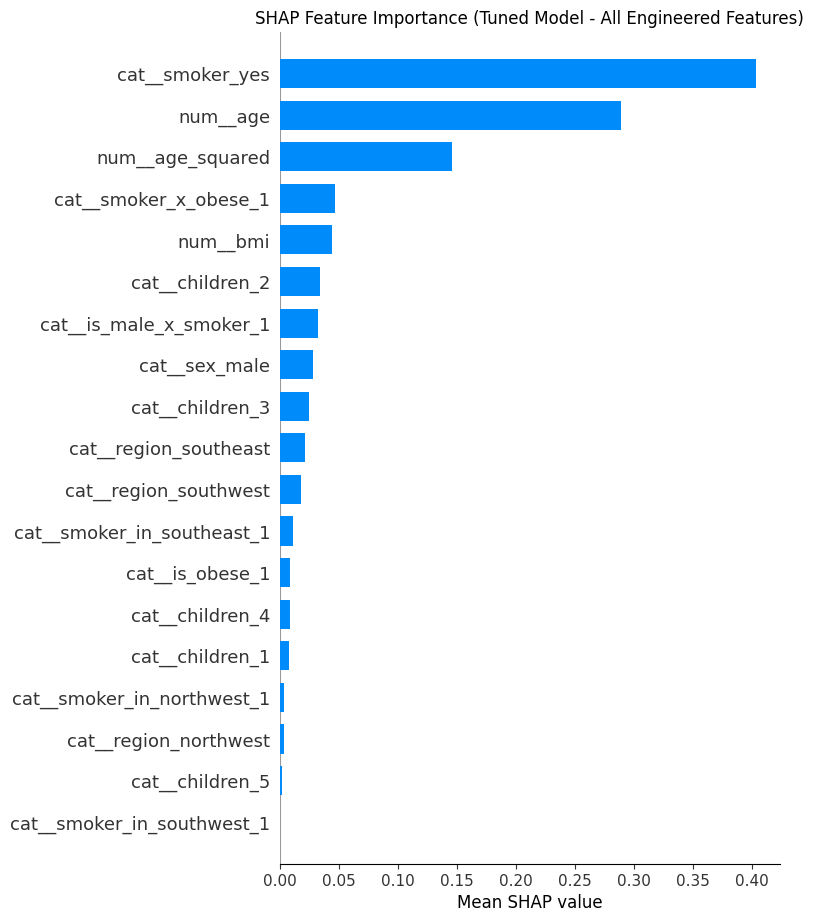

<Figure size 1600x1200 with 0 Axes>

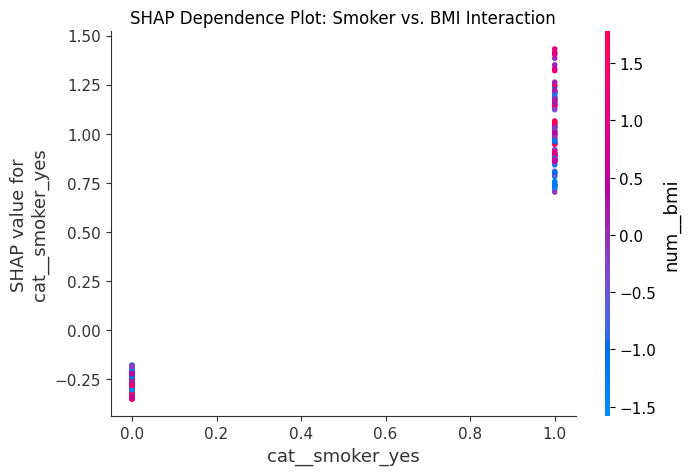

In [ ]:
print("\n--- 4. SHAP Analysis: Feature Impact (In-Training) ---")

# Transform the training data using the pipeline's preprocessor.
initial_preprocessor = best_xgb_pipeline.named_steps['preprocessor']
X_train_full_transformed = initial_preprocessor.transform(X_train)

try:
    final_transformer = initial_preprocessor.named_steps['process_features']
    feature_names = final_transformer.get_feature_names_out()
except KeyError:
     # Fallback if the user's preprocessing structure is flat
     feature_names = initial_preprocessor.get_feature_names_out()

# Convert the transformed array into a DataFrame for SHAP analysis.
X_train_full_transformed_df = pd.DataFrame(X_train_full_transformed, columns=feature_names)
initial_xgb_model = best_xgb_pipeline.named_steps['model']

# Select a small sample for faster SHAP calculation.
X_sample = X_train_full_transformed_df.sample(n=500, random_state=42)

try:
    explainer = shap.Explainer(initial_xgb_model.predict, X_sample)
    print("SHAP Explainer initialized successfully using model-agnostic approach.")
    shap_values = explainer(X_sample)
    print("SHAP values calculated successfully on training sample.")

except Exception as e:
    print(f"CRITICAL SHAP ERROR: Explainer initialization failed: {e}")
    sys.exit(1)

# Generate SHAP Summary Plot (Bar) for global feature importance.
plt.figure(figsize=(5, 3))
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance (Tuned Model - All Engineered Features)')
plt.xlabel('Mean SHAP value', fontsize=12)
plt.show()

# Generate a SHAP Dependence Plot for the most critical feature (Smoker).
if 'cat__smoker_yes' in X_sample.columns:
    smoker_feature_name = 'cat__smoker_yes'
    interaction_feature = 'num__bmi'
elif 'smoker_yes' in X_sample.columns:
    smoker_feature_name = 'smoker_yes'
    interaction_feature = 'bmi'
else:
    smoker_feature_name = None

if smoker_feature_name in X_sample.columns:
    plt.figure(figsize=(16, 12))
    shap.dependence_plot(
        smoker_feature_name, shap_values.values, X_sample, # Use .values here
        interaction_index=interaction_feature,
        show=False
    )
    plt.title('SHAP Dependence Plot: Smoker vs. BMI Interaction')
    plt.show()
else:
    print("WARNING: Could not find smoker feature name to generate Dependence Plot.")

SHAP Summary Plot (Bar)
- It shows the average magnitude of the impact each feature has on the model's prediction across  data points
- Smoker status is the dominant factor:
  - The feature cat__smoker_yes has the largest mean absolute SHAP value
  - Smoker status is the  most important predictor of insurance charges in your model (whether a person smokes or not creates the largest difference in the predicted outcome)
- Age:
  - num__age and num__age_square are the next most significant predictors.
  - Charges don't just increase linearly with age; the rate of increase itself accelerates as people get older. This non-linear relationship (shown by age_squared) is very important to the model.
- Engineered interaction features:
  - Interaction features like cat__smoker_x_obese_1 and cat__is_male_x_smoker_1 appear significantly higher than simple features like num__bmi or cat__sex_male.
  - The model does not just look at obesity or gender in isolation.
  - the combination of smoking plus obesity or smoking plus being male leads to a disproportionately higher predicted cost than the individual factors would suggest
    - feature engineering was highly effective.
- Least Important Factors:
  - Features related to Region and the specific Number of Children (cat__children_...) have very low average SHAP values
  - their influence on the final charge prediction is minimal compared to smoking and age.

SHAP Dependence Plot for cat__smoker_yes, with the color gradient showing the interaction with num__bmi
- Smokers vs. Non-Smokers:
  - Non-Smokers (X=0): The SHAP values are clustered around -0.25.
    - Being a non-smoker consistently contributes a large negative value to the predicted log-charge, significantly reducing the predicted cost.
  - Smokers (X=1.0): The SHAP values are clustered between 0.75 and 1.50
    - Being a smoker consistently contributes a large positive value, significantly increasing the predicted log-charge.
- The BMI Interaction (Color):
  - The points with the highest SHAP values are colored dark pink/red which correspond to high BMI.
    - Among smokers, individuals with a higher BMI have an even higher predicted cost than smokers with a lower BMI.
      - This confirms the powerful interaction the model learned: Smoking is bad, but Smoking + High BMI is the most expensive combination.

## Feature importance plot (using gain to rank importance)
- XGBoost is trained by maximizing gain. Using the gain metric directly reflects which features contributed the most to the actual reduction in your error (RMSE).
- Higher gain means the feature, when used, contributes more to overall prediction accuracy. This is a measure of impact.
- It gives a more accurate picture of a feature's true predictive power.
- Features like smoker and age tend to drive massive initial splits, separating the data into high-cost and low-cost groups. The gain metric correctly highlights these highly impactful features over minor, frequently used features (if used weight / count).

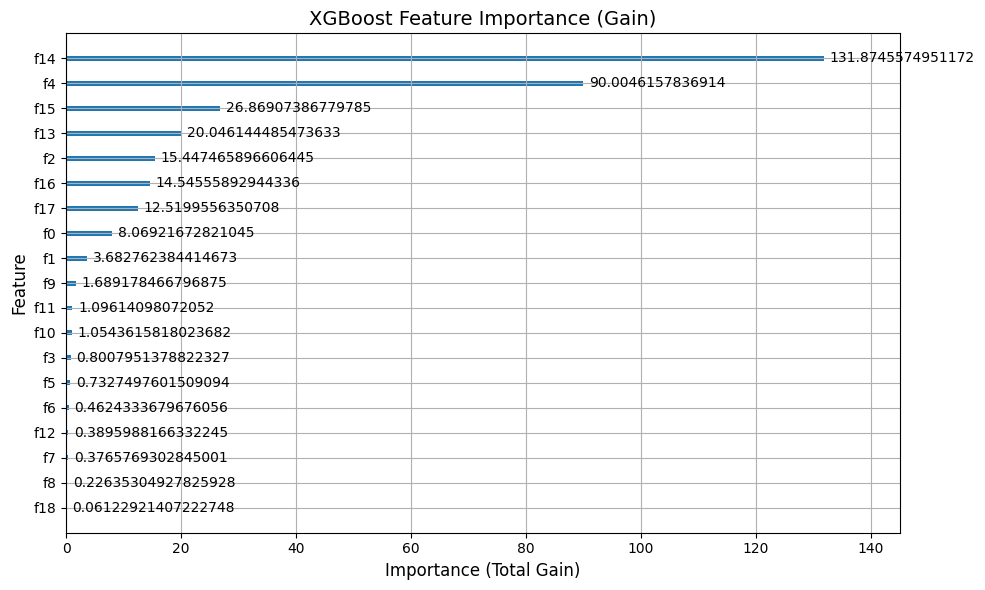

In [ ]:
best_xgb_model_plot = best_xgb_pipeline.named_steps['model']

# Using 'gain' importance type to rank importance XGBoost
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb_model_plot, ax=plt.gca(), importance_type='gain',
                    title='XGBoost Feature Importance (Total Gain)')
plt.title('XGBoost Feature Importance (Gain)', fontsize=14)
plt.ylabel('Feature', fontsize=12)
plt.xlabel('Importance (Total Gain)', fontsize=12)
plt.tight_layout()

# Save the plot for the slides
# plot_save_path = project_path + 'XGBoost_Importance_Plot.png'
# plt.savefig(plot_save_path)
# print(f"\nFeature Importance Plot saved as: {plot_save_path}")

# # Using "weight" or "count" to rank
# xgb.plot_importance(best_xgb_model_plot, ax=plt.gca(), importance_type='weight', title='XGBoost Feature Importance (Raw Count)')
# plt.title('XGBoost Feature Importance (Raw Count of Splits)')
# plt.tight_layout()
# plt.savefig('XGBoost_Importance_Plot.png')
# plt.show()